# 💹Gerekli kütüphanelerin yüklenmesi

In [1]:
# Veri işleme ve analiz için temel kütüphaneler
import pandas as pd
import numpy as np

# Derin öğrenme için TensorFlow ve Keras modülleri
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

# Görüntü verisini yüklemek ve ön işleme için
from keras_preprocessing.image import ImageDataGenerator

# Dosya ve yol işlemleri için
from pathlib import Path
import os.path

# Eğitim-veri ayrımı ve değerlendirme metrikleri için scikit-learn modülleri
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Görselleştirme için matplotlib
import matplotlib.pyplot as plt

# Uyarı mesajlarını gizlemek için
import warnings
warnings.filterwarnings("ignore")

# Veri Setini Yükleme ve Görüntü Yollarını Hazırlama

In [2]:
# 📌 Dataset klasörünün yolu (buraya kendi klasör yolunu veriyorsun)
dataset = "DrugsAndVitamins_Dataset/Drug Vision/Data Combined"

# 📂 path nesnesi oluşturuluyor
image_dir = Path(dataset)

# 🔍 Alt klasörlerdeki tüm .jpg ve .png uzantılı görselleri listele
file_path = list(image_dir.glob(r"**/*.jpg")) + list(image_dir.glob(r"**/*.png"))

# 🏷️ Görsel dosyasının bulunduğu klasör ismini (etiketleri) çıkart
# Her görselin bir üst klasörü etiket olarak kullanılıyor
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

# 🔄 Görsel yollarını ve etiketleri pandas Series formatına çevir
file_path = pd.Series(file_path, name="filepath").astype("str")
labels = pd.Series(labels, name="label")

# 🧩 Görsel yolları ve etiketleri tek bir DataFrame'de birleştir
image_df = pd.concat([file_path, labels], axis=1)

# 🔍 İlk birkaç satırı görüntüle (kontrol amaçlı)
image_df.head()

,filepath,label
0,DrugsAndVitamins_Dataset\Drug Vision\Data Comb...,Alaxan
1,DrugsAndVitamins_Dataset\Drug Vision\Data Comb...,Alaxan
2,DrugsAndVitamins_Dataset\Drug Vision\Data Comb...,Alaxan
3,DrugsAndVitamins_Dataset\Drug Vision\Data Comb...,Alaxan
4,DrugsAndVitamins_Dataset\Drug Vision\Data Comb...,Alaxan


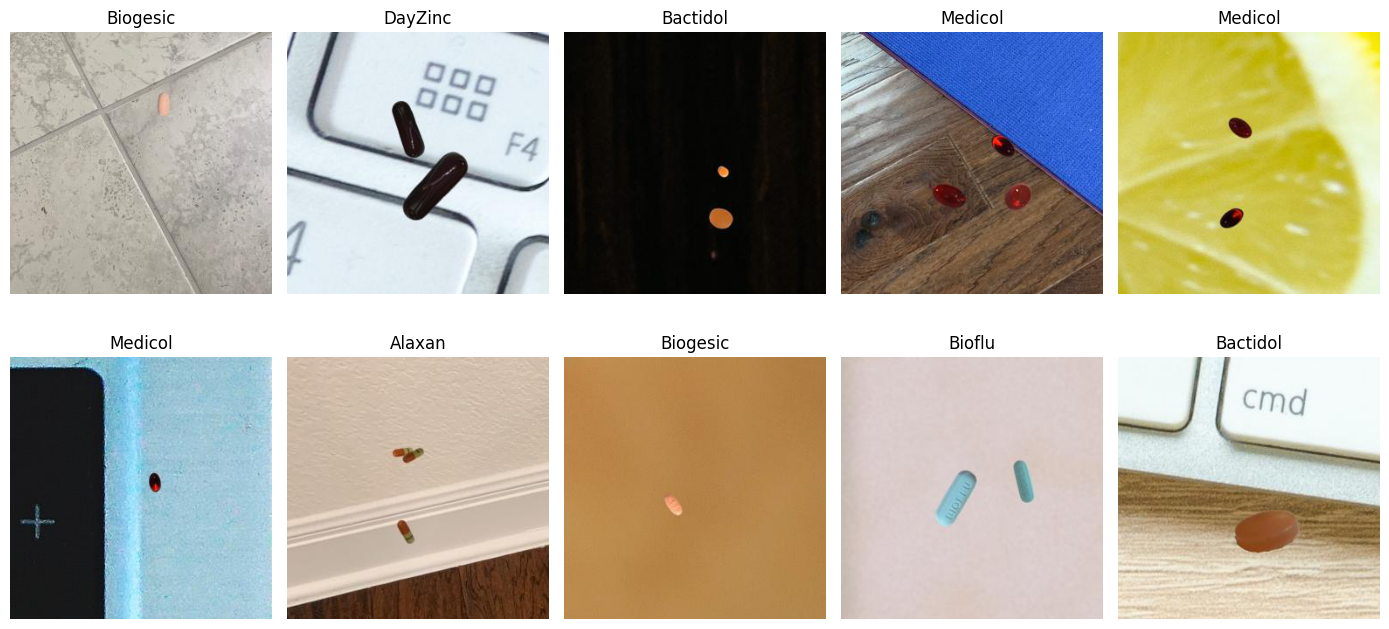

In [3]:
random_index = np.random.randint(0, len(image_df), 25)

fig, axs = plt.subplots(2,5, figsize = (14,7))

for i,ax in enumerate(axs.flatten()):
    ax.imshow(plt.imread(image_df.filepath[random_index[i]]))
    ax.set_title(image_df.label[random_index[i]])
    ax.axis("off")

plt.tight_layout()
plt.show()

# 🧪 Veri Setinin Eğitim, Doğrulama ve Test Olarak Bölünmesi & Görsel Üreticilerin Tanımlanması

In [4]:
# 🔀 Veri setini %80 eğitim, %20 test olarak bölüyoruz
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=23)

# 🧪 Eğitim veri üretici (augmentasyon) tanımı (ayrıca %20 validation için)
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2 # Eğitim verisinin %20'si doğrulama olarak ayrılacak
)

# 🧪 Test veri üretici tanımı (validation_split yok çünkü test için tüm veri kullanılacak)
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# 🏋️‍♂️ Eğitim görüntüleri: image_df tüm veri setinden alınmış
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,               
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=23,
    subset="training"                # Eğitim alt kümesi
)

# 🧪 Doğrulama görüntüleri
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,              
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64,
    shuffle=True,
    seed=34,
    subset="validation"             # Doğrulama alt kümesi
)

# 🔍 Test görüntüleri
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=64
)

Found 6400 validated image filenames belonging to 10 classes.
Found 1600 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


# 🧠 Model Mimarisi (Transfer Learning ile), Callback'ler ve Eğitim Süreci

In [18]:
# 🔄 MobileNetV2 modelini yükle: ImageNet ile önceden eğitilmiş, en üst katmanlar dahil değil
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,       # En üstteki (sınıflandırıcı) katmanları dahil etme
    weights="imagenet",      # ImageNet verisiyle eğitilmiş ağırlıkları kullan
    pooling="avg"            # GlobalAveragePooling2D yerine 'avg' kullan (özellik vektörü)
)

# 🔒 Önceden eğitilmiş katmanları dondur (eğitim sırasında ağırlıkları değişmeyecek)
pretrained_model.trainable = False

# 💾 En iyi model ağırlıklarını kaydetmek için ModelCheckpoint callback'i
checkpoint_path = "drugs_and_vitamins_model_checkpoint.weights.h5"  # ✅ .weights.h5 uzantısı gerekli

checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,           # Sadece doğrulama başarımı en iyi olduğunda kaydet
    monitor="val_accuracy",        # Doğrulama doğruluğu izlenecek metrik
    save_weights_only=True         # Sadece ağırlıkları kaydet (model yapısı değil)
)

# ⏹️ Eğitim doğrulama doğruluğu gelişmezse erken durdurmak için callback
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,                    # 5 epoch boyunca gelişme olmazsa durdur
    restore_best_weights=True      # En iyi epoch’taki ağırlıkları geri yükle
)

# 🧱 Yeni model mimarisi: pretrained_model + kendi dense katmanlarımız
inputs = pretrained_model.input       # Girdi: (224, 224, 3)
x = pretrained_model.output           # Çıktı: Özellik vektörü

# 🔧 Ek dense katmanlar (özellikleri öğrenme kısmı)
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.3)(x)

# 🎯 Çıkış katmanı: 10 sınıflı softmax aktivasyonu
output = Dense(10, activation="softmax")(x)

# 🧠 Modelin tamamını birleştir
model = Model(inputs=inputs, outputs=output)

# ⚙️ Modeli derle: çok sınıflı sınıflandırma için uygun yapı
model.compile(
    loss="categorical_crossentropy",     # Çoklu sınıf kaybı
    optimizer=Adam(learning_rate=1e-3),  # Adam optimizasyon algoritması
    metrics=["accuracy"]                 # Başarı metriği: doğruluk
)

# 🏁 Modeli eğit
history = model.fit(
    train_images,                        # Eğitim verileri
    steps_per_epoch=len(train_images),   # Her epoch'ta kaç batch işlenecek
    validation_data=val_images,         # Doğrulama verileri
    validation_steps=len(val_images),   # Doğrulama adımları
    epochs=10,                            # Eğitim kaç kez tekrar edilecek
    callbacks=[early_stopping, checkpoint_callback]  # Callbacks
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3622 - loss: 1.8009 - val_accuracy: 0.7850 - val_loss: 0.6864
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.7247 - loss: 0.7957 - val_accuracy: 0.8181 - val_loss: 0.5373
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8015 - loss: 0.5790 - val_accuracy: 0.8338 - val_loss: 0.5152
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.8270 - loss: 0.5132 - val_accuracy: 0.8244 - val_loss: 0.5214
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8515 - loss: 0.4158 - val_accuracy: 0.8506 - val_loss: 0.4593
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8773 - loss: 0.3557 - val_accuracy: 0.8394 - val_loss: 0.4876
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.8781 - loss: 0.3487 - val_accuracy: 0.8269 - val_loss: 0.5664
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8928 - loss: 0.3071 - val_accu

# 🧪Test Verisi ile Değerlendirme (Model Performance)

In [19]:
# 📊 Test verileri üzerinde modelin kayıp (loss) ve doğruluk (accuracy) değerlerini hesapla
loss, accuracy = model.evaluate(test_images, verbose=1)

# 📢 Sonuçları güzel biçimde yazdır
print(f"Test loss: {loss:.2f}, Test accuracy: {accuracy:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8353 - loss: 0.5115 
Test loss: 0.52, Test accuracy: 0.83


# 📈Eğitim Süreci Görselleştirme (Training History Visualization)

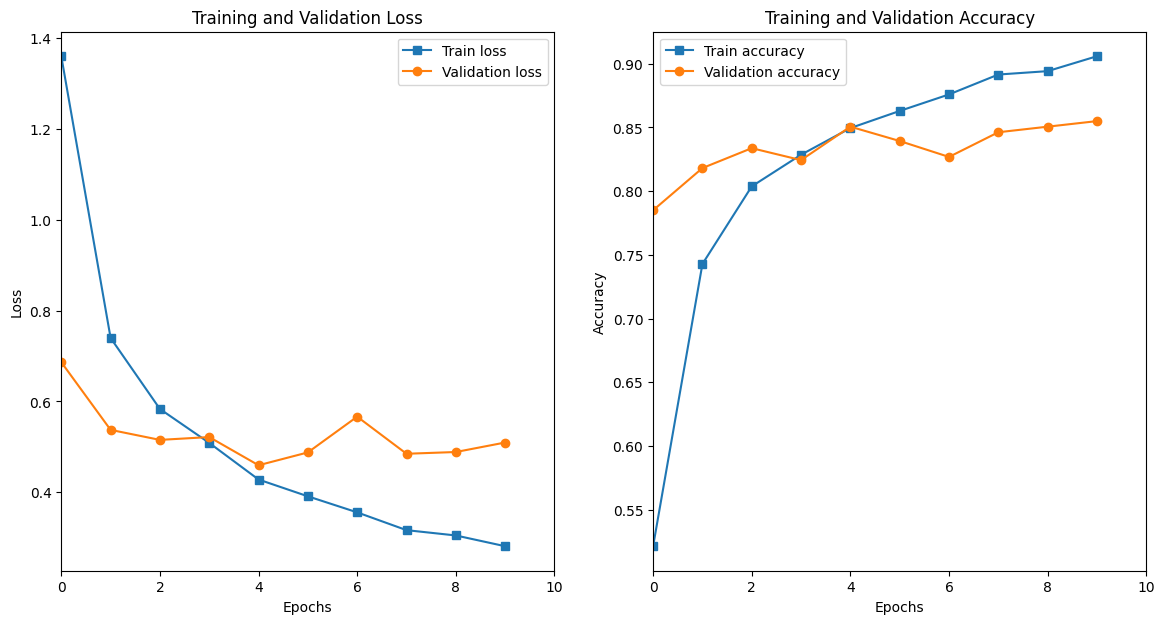

In [25]:
# 📜 history nesnesinden metrik verilerini al
#history = history.history 

# 📊 1 satır 2 sütunluk grafik alanı oluştur
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# 🎯 Kayıp (Loss) grafiği
ax[0].plot(history["loss"], "s-", label="Train loss")
ax[0].plot(history["val_loss"], "o-", label="Validation loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlim([0,10])
ax[0].legend()

# ✅ Doğruluk (Accuracy) grafiği
ax[1].plot(history["accuracy"], "s-", label="Train accuracy")
ax[1].plot(history["val_accuracy"], "o-", label="Validation accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Training and Validation Accuracy")
ax[1].set_xlim([0,10])
ax[1].legend()

# 🖼️ Grafiklerin gösterilmesi
plt.show()